# MiBiReMo Example 1: Calcite Titration Curve

This notebook models the reaction:

$$\mathrm{CaCO_3(s) + 2HCl(aq) \rightarrow CaCl_2(aq) + CO_2(g) + H_2O(l)}$$

assuming chemical reactions at equilibrium.

Author: Matteo Masi  
Last revision: 09/06/2025

### Import libraries

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import mibiremo

### Global Settings

In [2]:
# Global settings
database_path = "../mibiremo/database/phreeqc.dat"  # .dat database path
n_cells = 1000  # Number of model cells
n_threads = 4  # Multithread calculation (-1 for all CPUs)
pqi_file = "pqi/ex1_Calcite_titration.pqi"  # Phreeqc input file
hcl_range = [0.0, 4.0]  # mol/L

# Unit settings
unit_solution = 2  # 1: mg/L; 2: mol/L; 3: kg/kgs
units = 1  # 0: mol/L cell; 1: mol/L water; 2: mol/L rock

# Physical properties
porosity = 1.0  # Porosity
saturation = 1.0  # Saturation

### Initialize PhreeqcRM

In [ ]:
def initialize_phreeqc():
    """Initialize and configure PhreeqcRM instance."""
    phr = mibiremo.PhreeqcRM()
    phr.create(nxyz=n_cells, n_threads=n_threads)

    # Load database
    status = phr.RM_LoadDatabase(database_path)
    if status != 0:
        raise RuntimeError("Failed to load Phreeqc database")

    # Set properties/parameters
    phr.RM_SetComponentH2O(0)  # Don't include H2O in component list
    phr.RM_SetRebalanceFraction(0.5)  # Rebalance thread load

    # Set units
    phr.RM_SetUnitsSolution(unit_solution)
    phr.RM_SetUnitsPPassemblage(units)
    phr.RM_SetUnitsExchange(units)
    phr.RM_SetUnitsSurface(units)
    phr.RM_SetUnitsGasPhase(units)
    phr.RM_SetUnitsSSassemblage(units)
    phr.RM_SetUnitsKinetics(units)

    # Set porosity and saturation
    phr.RM_SetPorosity(porosity * np.ones(n_cells))
    phr.RM_SetSaturation(saturation * np.ones(n_cells))

    # Create error log files
    phr.RM_SetFilePrefix("titr")
    phr.RM_OpenFiles()

    # Multicomponent diffusion settings
    phr.RM_SetSpeciesSaveOn(1)

    return phr

### Run Initial Setup and Retrieve Component/Species Info

In [4]:
def run_initial(phr):
    """Run initial setup and return component/species information."""
    # Run the initial setup file
    status = phr.RM_RunFile(1, 1, 1, pqi_file)
    if status != 0:
        raise RuntimeError("Failed to run Phreeqc input file")

    # Log thread information
    th = phr.RM_GetThreadCount()
    phr.RM_OutputMessage(f"Number of threads: {th}\n")

    # Transfer initial conditions
    ic1 = -1 * np.ones(n_cells * 7, dtype=np.int32)
    for i in range(n_cells):
        ic1[i] = 1  # Solution 1
        ic1[i + n_cells] = 1  # Equilibrium phases 1
        # Other phases set to none (-1)
        ic1[i + 2*n_cells:i + 7*n_cells] = -1

    ic2 = -1 * np.ones(n_cells * 7, dtype=np.int32)
    f1 = np.ones(n_cells * 7, dtype=np.float64)

    status = phr.RM_InitialPhreeqc2Module(ic1, ic2, f1)

    # Get component and species information
    n_comps = phr.RM_FindComponents()
    n_species = phr.RM_GetSpeciesCount()

    components = np.zeros(n_comps, dtype="U20")
    for i in range(n_comps):
        phr.RM_GetComponent(i, components, 20)

    species = np.zeros(n_species, dtype="U20")
    for i in range(n_species):
        phr.RM_GetSpeciesName(i, species, 20)

    # Run initial equilibrium step
    phr.RM_SetTime(0.0)
    phr.RM_SetTimeStep(0.0)
    status = phr.RM_RunCells()

    return components, species

### Initialize PhreeqcRM and Run Initial Setup

In [7]:
phr = initialize_phreeqc()
components, species = run_initial(phr)
n_comps = len(components)
n_species = len(species)

# Show components and species
display("Components:")
for comp in components:
    print(f"  {comp}")
print("\nSpecies:")
for spec in species:
    print(f"  {spec}")

'Components:'

  H
  O
  Charge
  C
  Ca
  Cl
  Na

Species:
  (CO2)2
  CH4
  CO2
  CO3-2
  Ca+2
  CaCO3
  CaHCO3+
  CaOH+
  Cl-
  H+
  H2
  H2O
  HCO3-
  Na+
  NaCO3-
  NaHCO3
  NaOH
  O2
  OH-


### Prepare Concentration Vectors and HCl Range

In [9]:
# Initialize concentration vectors
cc = np.zeros(n_cells * n_comps, dtype=np.float64)
cs = np.zeros(n_cells * n_species, dtype=np.float64)
phr.RM_GetConcentrations(cc)
phr.RM_GetSpeciesConcentrations(cs)

# Set HCl concentrations
hcl = np.linspace(hcl_range[0], hcl_range[1], n_cells)  # mol/L

# Find indices for Cl- and H+ species
indx_cl = np.where(species == "Cl-")[0][0]
indx_h = np.where(species == "H+")[0][0]

# Update species concentrations with HCl
cs_r = cs.reshape(n_species, n_cells).T
cs_r[:, indx_cl] += hcl  # Cl-
cs_r[:, indx_h] += hcl  # H+
cs1 = cs_r.T.reshape(n_cells * n_species)

### Run Simulation with Added HCl

In [10]:
phr.RM_SpeciesConcentrations2Module(cs1)
phr.RM_SetTime(1.0)
phr.RM_SetTimeStep(1.0)

start_time = time.time()
phr.RM_RunCells()
elapsed = time.time() - start_time
print(f"Simulation completed in {elapsed:.2f} seconds")

Simulation completed in 0.04 seconds


### Retrieve and Plot Results

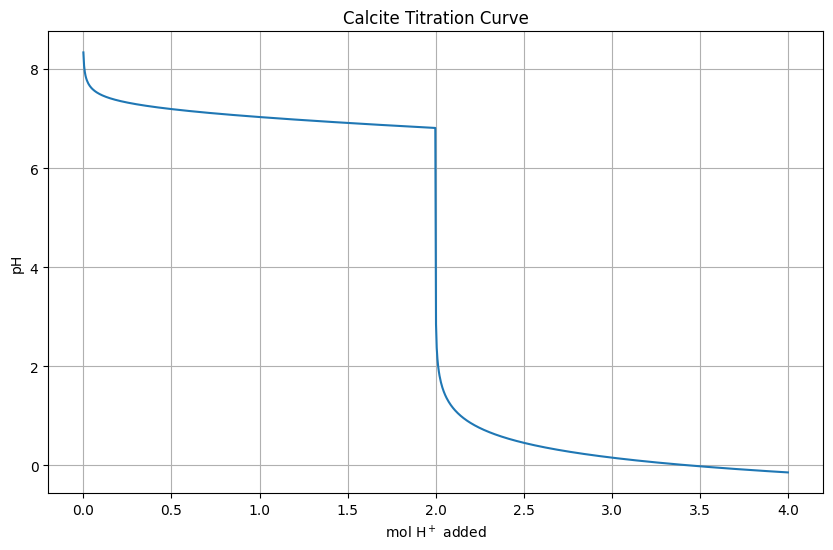

In [11]:
results_df = phr.pdSelectedOutput()

plt.figure(figsize=(10, 6))
plt.plot(hcl, results_df['pH'])
plt.xlabel("mol H$^+$ added")
plt.ylabel("pH")
plt.title("Calcite Titration Curve")
plt.grid(True)
plt.show()